In [1]:
import os
import json
from pathlib import Path
import typing

import numpy as np
import torch
from transformers import OpenAIGPTLMHeadModel, OpenAIGPTConfig
from muutils.logger import Logger, TimerContext
from muutils.json_serialize import json_serialize, dataclass_serializer_factory
from muutils.tensor_utils import ATensor
from muutils.statcounter import StatCounter
from muutils.misc import shorten_numerical_to_str

from maze_transformer.generation.latticemaze import LatticeMaze
from maze_transformer.generation.generators import LatticeMazeGenerators
from maze_transformer.training.tokenizer import SolvedMaze, SPECIAL_TOKENS
from maze_transformer.training.mazedataset import MazeDatasetConfig, MazeDataset
from maze_transformer.evaluation.plot_maze import plot_multi_paths
from maze_transformer.training.dataset import GPTDatasetConfig
from maze_transformer.training.config import TrainConfig
from maze_transformer.training.training import TRAIN_SAVE_FILES
from maze_transformer.evaluation.eval_model import plot_predicted_path



Input length of input_ids is 90, but ``max_length`` is set to 5. This can lead to unexpected behavior. You should consider increasing ``config.max_length`` or ``max_length``.


loaded model with 28M parameters
maze tokens: ['<ADJLIST_START>', '(3,3)', '<-->', '(3,3)', ';', '(2,2)', '<-->', '(2,3)', ';', '(2,3)', '<-->', '(3,3)', ';', '(1,2)', '<-->', '(1,3)', ';', '(3,0)', '<-->', '(3,1)', ';', '(3,0)', '<-->', '(3,0)', ';', '(1,3)', '<-->', '(1,3)', ';', '(2,0)', '<-->', '(2,1)', ';', '(1,1)', '<-->', '(2,1)', ';', '(0,3)', '<-->', '(0,3)', ';', '(0,1)', '<-->', '(1,1)', ';', '(3,2)', '<-->', '(3,2)', ';', '(0,2)', '<-->', '(0,2)', ';', '(1,2)', '<-->', '(1,2)', ';', '(1,0)', '<-->', '(1,0)', ';', '(2,0)', '<-->', '(2,0)', ';', '<ADJLIST_END>', '<TARGET_START>', '(3,3)', '<TARGET_END>', '<START_PATH>']
tensor([[ 8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
          8,  8,  0, 24,  6, 24,  7, 19,  6, 20,  7, 20,  6, 24,  7, 15,  6, 16,
          7, 21,  6, 22,  7, 21,  6, 21,  7, 16,  6, 16,  7, 17,  6, 18,  7, 14,
          6, 18,  7, 12,  6, 12,  7, 10,  6, 14,  7, 23,  6, 23,  7, 11,  6, 11,
          7, 15,  6, 15,  7, 13,  6, 1

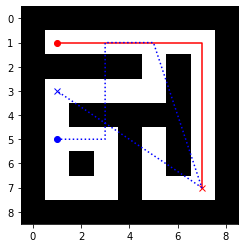

In [2]:


plot_predicted_path("data/g4-n4K/g4-n4K_tiny-v1_2022-09-10-02-02-12/checkpoints/model.iter_3120.pt")
